In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

Getting data

In [2]:
df = pd.read_csv("final_df.csv")

In [3]:
#formatting the dataframe
df.rename(columns = {'Unnamed: 0': 'Year'}, inplace=True)
df = df.set_index('Year')

In [5]:
#Dropping price high and price low
df.drop(['Price high', 'Price low'], axis=1, inplace=True)

In [6]:
df.head()

,Long-Term Debt,Revaluation Reserves,Total Equity,"Net Property, Plant & Equipment",Capitalized Lease Obligations,Retained Earnings,Treasury Stock,Total Assets,Preferred Stock (Carrying Value),Common Stock Par/Carry Value,Total Shareholders' Equity,Accumulated Minority Interest,Total Liabilities,Non-Redeemable Preferred Stock,Other Liabilities,Intangible Assets,Liabilities & Shareholders' Equity,Redeemable Preferred Stock,Other Liabilities (excl. Deferred Income),Total Shareholders' Equity / Total Assets,Target,Short Term Debt,ESOP Debt Guarantee,Cumulative Translation Adjustment/Unrealized For. Exch. Gain,Common Equity / Total Assets,Common Equity (Total)
Year,,,,,,,,,,,,,,,,,,,,,,,,,,
2016,21.818182,0.0,-9.851787,0.000000,-2.173913,4.435262,9.094809,0.091241,0.0,0.000000,-9.886264,15.384615,5.322129,0.0,2.564103,-3.037975,0.091241,0.0,3.478261,-9.953970,Buy,-91.568627,0.0,19.642857,-9.953970,-9.886264
2017,13.432836,0.0,12.379110,4.107981,33.333333,3.191770,1.808887,15.436038,0.0,0.000000,12.233010,31.111111,16.888298,0.0,95.833333,17.058312,15.436038,0.0,97.478992,-2.747604,Hold,336.627907,0.0,-18.407960,-2.747604,12.233010
2018,10.937500,0.0,-15.232358,-1.465614,25.000000,3.885481,14.445732,-3.922085,0.0,0.000000,-15.224913,-11.864407,1.061813,0.0,0.425532,-5.501859,-3.922085,0.0,0.425532,-11.826544,Sell,-37.949401,0.0,28.048780,-11.826544,-15.224913
2016,252.299830,0.0,-2.859822,-0.349040,0.000000,-0.737578,1.600753,25.022727,0.0,2.356638,-3.158887,55.652174,51.190476,0.0,26.229508,-19.605263,25.022727,0.0,26.229508,-22.567932,Buy,-57.827476,0.0,2.691511,-22.567932,-3.158887
2017,31.576402,0.0,50.096525,33.274956,0.000000,-6.218224,-5.189991,38.611162,0.0,78.127398,50.438169,12.290503,31.671041,0.0,184.415584,272.258592,38.611162,0.0,184.415584,8.545406,Buy,-84.393939,0.0,-30.443548,8.545406,50.438169


Exploratory Data Analysis

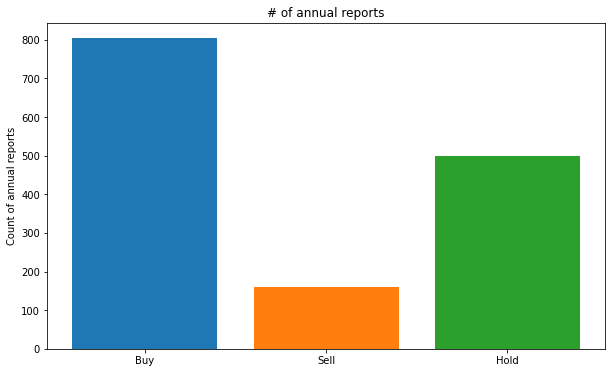

In [9]:
plt.figure(figsize = (10,6))
plt.bar("Buy", df.groupby(['Target']).count().loc['Buy'][0])
plt.bar("Sell", df.groupby(['Target']).count().loc['Sell'][0])
plt.bar("Hold", df.groupby(['Target']).count().loc['Hold'][0])

plt.ylabel("Count of annual reports")
plt.title("# of annual reports")
plt.show()

In [10]:
#Replacing "Buy","Sell" and "Hold" as 0,1,2
target = {'Sell':0, 'Hold':1, 'Buy':2}
df.Target = [target[item] for item in df.Target]
df

,Long-Term Debt,Revaluation Reserves,Total Equity,"Net Property, Plant & Equipment",Capitalized Lease Obligations,Retained Earnings,Treasury Stock,Total Assets,Preferred Stock (Carrying Value),Common Stock Par/Carry Value,Total Shareholders' Equity,Accumulated Minority Interest,Total Liabilities,Non-Redeemable Preferred Stock,Other Liabilities,Intangible Assets,Liabilities & Shareholders' Equity,Redeemable Preferred Stock,Other Liabilities (excl. Deferred Income),Total Shareholders' Equity / Total Assets,Target,Short Term Debt,ESOP Debt Guarantee,Cumulative Translation Adjustment/Unrealized For. Exch. Gain,Common Equity / Total Assets,Common Equity (Total)
Year,,,,,,,,,,,,,,,,,,,,,,,,,,
2016,21.818182,0.0,-9.851787,0.000000,-2.173913,4.435262,9.094809,0.091241,0.000000,0.000000,-9.886264,15.384615,5.322129,0.0,2.564103,-3.037975,0.091241,0.0,3.478261,-9.953970,2,-9.156863e+01,0.0,19.642857,-9.953970,-9.886264
2017,13.432836,0.0,12.379110,4.107981,33.333333,3.191770,1.808887,15.436038,0.000000,0.000000,12.233010,31.111111,16.888298,0.0,95.833333,17.058312,15.436038,0.0,97.478992,-2.747604,1,3.366279e+02,0.0,-18.407960,-2.747604,12.233010
2018,10.937500,0.0,-15.232358,-1.465614,25.000000,3.885481,14.445732,-3.922085,0.000000,0.000000,-15.224913,-11.864407,1.061813,0.0,0.425532,-5.501859,-3.922085,0.0,0.425532,-11.826544,0,-3.794940e+01,0.0,28.048780,-11.826544,-15.224913
2016,252.299830,0.0,-2.859822,-0.349040,0.000000,-0.737578,1.600753,25.022727,0.000000,2.356638,-3.158887,55.652174,51.190476,0.0,26.229508,-19.605263,25.022727,0.0,26.229508,-22.567932,2,-5.782748e+01,0.0,2.691511,-22.567932,-3.158887
2017,31.576402,0.0,50.096525,33.274956,0.000000,-6.218224,-5.189991,38.611162,0.000000,78.127398,50.438169,12.290503,31.671041,0.0,184.415584,272.258592,38.611162,0.0,184.415584,8.545406,2,-8.439394e+01,0.0,-30.443548,8.545406,50.438169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0.198828,0.0,0.655308,6.862745,35.135135,21.120690,0.000000,4.776166,-20.236753,-5.720339,0.655308,0.000000,5.339545,-100.0,-39.384289,0.000000,4.776166,0.0,-39.384289,-3.990025,1,5.019800e+02,0.0,0.000000,-1.924840,2.745665
2018,89.033943,0.0,-1.302083,2.752294,300.000000,23.131673,0.000000,3.715962,0.000000,-100.000000,-1.302083,0.000000,4.371492,566000000.0,10.858144,0.000000,3.715962,0.0,10.858144,-4.848485,1,1.345382e+01,0.0,0.000000,-4.953271,-1.406470
2016,0.224215,0.0,37.614679,5.343511,0.000000,68.949772,107.389163,-3.286979,0.000000,0.000000,39.252336,-47.826087,-9.824047,0.0,18.852459,2.264151,-3.286979,0.0,18.852459,44.000000,2,-1.000000e+02,0.0,-3.476821,44.000000,39.252336


In [14]:
#Splitting into target and independent variables
target = df['Target']
df.drop(['Target'], axis=1, inplace=True)

Feature Selection

In [15]:
forest = ExtraTreesClassifier(n_estimators=200)
%timeit forest.fit(df,target)

1 loop, best of 5: 747 ms per loop


In [17]:
#determining the important features
importances = forest.feature_importances_

#standard deviation among the trees for the important features
std = np.std([i.feature_importances_ for i in forest.estimators_], axis=0)

#indexing and sorting the important features
indices = np.argsort(importances)[::-1]

In [18]:
indices

array([20,  5, 12,  3, 16,  7, 15,  0, 11, 14,  6,  2, 22, 10, 24, 18, 19,
       23,  4,  9,  8, 13, 17, 21,  1])

Feature Rankings:
1. Short Term Debt: 0.05451174147457667
2. Retained Earnings: 0.053258342765940464
3. Total Liabilities: 0.05275755508410762
4. Net Property, Plant & Equipment: 0.051896242230248454
5. Liabilities & Shareholders' Equity: 0.051707915511511666
6. Total Assets: 0.051649741585095305
7. Intangible Assets: 0.05161187289566937
8. Long-Term Debt: 0.05120873558424413
9. Accumulated Minority Interest: 0.04858001093854108
10. Other Liabilities: 0.04692083567670381
11. Treasury Stock: 0.046047534655385726
12. Total Equity: 0.04600914410092553
13. Cumulative Translation Adjustment/Unrealized For. Exch. Gain: 0.04590148168686102
14. Total Shareholders' Equity: 0.0447939677910302
15. Common Equity (Total): 0.044255603137247974
16. Other Liabilities (excl. Deferred Income): 0.043552366442290234
17. Total Shareholders' Equity / Total Assets: 0.04305893486063308
18. Common Equity / Total Assets: 0.04226183940841188
19. Capitalized Lease Obligations: 0.042021040157470865
20. Common Stoc

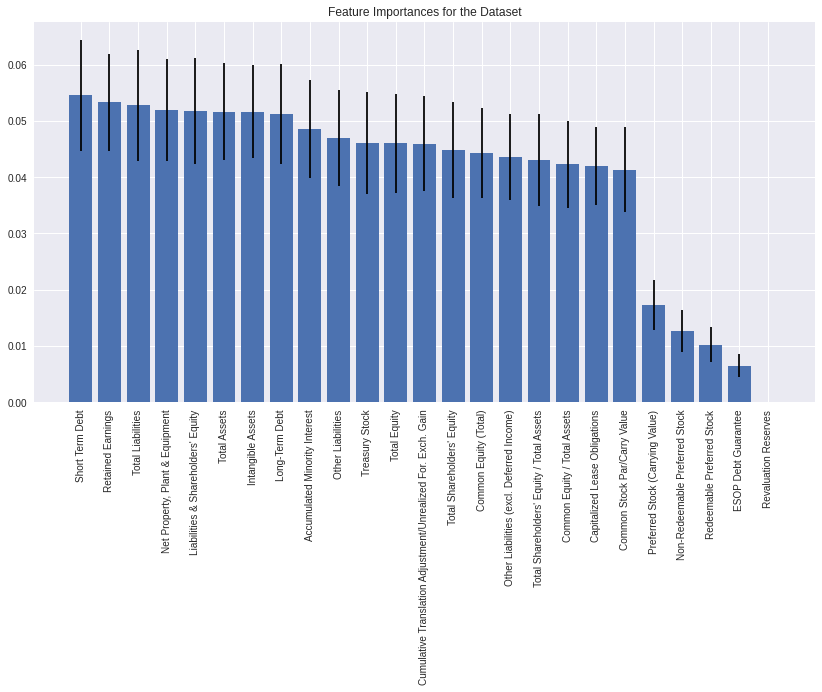

In [20]:
plt.style.use('seaborn')

print("Feature Rankings:")
ls = []

#printing top 20 features
for i in range(20):
  print(f"{i+1}. {df.columns[indices[i]]}: {importances[indices[i]]}")
  ls.append(df.columns[indices[i]])

#plotting top 20 features
plt.figure(figsize=(14,7))
plt.title("Feature Importances for the Dataset")
plt.bar(range(df.shape[1]), importances[indices], yerr=std[indices], align='center')
plt.xticks(range(df.shape[1]), df.columns[indices], rotation=90)
plt.show()

In [21]:
top20_df = df[ls]

In [22]:
top20_df['Target'] = target

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
top20_df.head()

,Short Term Debt,Retained Earnings,Total Liabilities,"Net Property, Plant & Equipment",Liabilities & Shareholders' Equity,Total Assets,Intangible Assets,Long-Term Debt,Accumulated Minority Interest,Other Liabilities,Treasury Stock,Total Equity,Cumulative Translation Adjustment/Unrealized For. Exch. Gain,Total Shareholders' Equity,Common Equity (Total),Other Liabilities (excl. Deferred Income),Total Shareholders' Equity / Total Assets,Common Equity / Total Assets,Capitalized Lease Obligations,Common Stock Par/Carry Value,Target
Year,,,,,,,,,,,,,,,,,,,,,
2016,-91.568627,4.435262,5.322129,0.000000,0.091241,0.091241,-3.037975,21.818182,15.384615,2.564103,9.094809,-9.851787,19.642857,-9.886264,-9.886264,3.478261,-9.953970,-9.953970,-2.173913,0.000000,2
2017,336.627907,3.191770,16.888298,4.107981,15.436038,15.436038,17.058312,13.432836,31.111111,95.833333,1.808887,12.379110,-18.407960,12.233010,12.233010,97.478992,-2.747604,-2.747604,33.333333,0.000000,1
2018,-37.949401,3.885481,1.061813,-1.465614,-3.922085,-3.922085,-5.501859,10.937500,-11.864407,0.425532,14.445732,-15.232358,28.048780,-15.224913,-15.224913,0.425532,-11.826544,-11.826544,25.000000,0.000000,0
2016,-57.827476,-0.737578,51.190476,-0.349040,25.022727,25.022727,-19.605263,252.299830,55.652174,26.229508,1.600753,-2.859822,2.691511,-3.158887,-3.158887,26.229508,-22.567932,-22.567932,0.000000,2.356638,2
2017,-84.393939,-6.218224,31.671041,33.274956,38.611162,38.611162,272.258592,31.576402,12.290503,184.415584,-5.189991,50.096525,-30.443548,50.438169,50.438169,184.415584,8.545406,8.545406,0.000000,78.127398,2


In [24]:
X = top20_df.drop(["Target"],1)
y = top20_df.Target

Splitting into train and test set

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

Classification

In [28]:
#Adaboost Classifier
pipe_ada = Pipeline([('scale',StandardScaler()), ('clf', AdaBoostClassifier())])

#Gradient Boost
pipe_gb = Pipeline([('scale',StandardScaler()), ('clf', GradientBoostingClassifier())])

#Random Forest
pipe_rf = Pipeline([('scale',StandardScaler()), ('clf', RandomForestClassifier())])

#Decision Tree
pipe_dt = Pipeline([('scale',StandardScaler()), ('clf', DecisionTreeClassifier())])

#Dummy (Baseline)
pipe_dum = Pipeline([('scale',StandardScaler()), ('clf', DummyClassifier())])

#K Nearest Neighbours
pipe_knn = Pipeline([('scale',StandardScaler()), ('clf', KNeighborsClassifier())])

#Logistic Regression
pipe_lr = Pipeline([('scale',StandardScaler()), ('clf', LogisticRegression())])

#Naive Bayes
pipe_nb = Pipeline([('scale',StandardScaler()), ('clf', GaussianNB())])

#Support Vector Machine
pipe_svm = Pipeline([('scale',StandardScaler()), ('clf', SVC())])

#XGBoost
pipe_xgb = Pipeline([('scale',StandardScaler()), ('clf', XGBClassifier())])

In [29]:
pipelines = [pipe_ada, pipe_gb, pipe_rf, pipe_dt, pipe_dum,
             pipe_knn, pipe_lr, pipe_nb, pipe_svm, pipe_xgb]

models = ['Adaboost',
          'GradientBoost',
          'RandomForest',
          'DecisionTree',
          'Dummy(Baseline)',
          'KNN',
          'LogisticRegression',
          'NaiveBayes',
          'SupportVectorMachine',
          'XGBoost']

model_pipelines = dict(zip(models, pipelines))

In [31]:
#Training of models
for name,pipe in model_pipelines.items():
  print(pipe)
  pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=1.0, n_estimators=50,
                                    random_state=None))],
         verbose=False)
Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                        

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)


Evaluating the models

In [32]:
models_f1 = {}
models_acc = {}

#looping through each model and getting their performance
for name, pipe in model_pipelines.items():
  print('\n' + name + ' F1 score:')

  #classification report
  report = classification_report(y_test, pipe.predict(X_test), target_names=['Sell','Buy','Hold'], output_dict=True)
  f1 = report['macro avg']['f1-score']
  acc = accuracy_score(y_test, pipe.predict(X_test))
  #assigning it to dictionary
  models_f1[name] = f1
  models_acc[name] = acc

  print(f1)
  print(acc)


Adaboost F1 score:
0.3143420807151392
0.5187713310580204

GradientBoost F1 score:
0.3400185158376539
0.5324232081911263

RandomForest F1 score:
0.34586176727909007
0.5221843003412969

DecisionTree F1 score:
0.35513547888325
0.45733788395904434

Dummy(Baseline) F1 score:
0.3249069043257376
0.45051194539249145

KNN F1 score:
0.33645595200929196
0.4948805460750853

LogisticRegression F1 score:
0.24885713503599685
0.552901023890785

NaiveBayes F1 score:
0.09744980969813184
0.11604095563139932

SupportVectorMachine F1 score:
0.2519325076884715
0.5631399317406144

XGBoost F1 score:
0.3558681318681319
0.552901023890785


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
#finding top 3 models
for i in sorted(models_f1, key=models_f1.get, reverse=True)[:3]:
  print(i, models_f1[i], models_acc[i])

XGBoost 0.3558681318681319 0.552901023890785
DecisionTree 0.35513547888325 0.45733788395904434
RandomForest 0.34586176727909007 0.5221843003412969


In [34]:
test_one_quarter = X_test.iloc[-1]
test_one_quarter

Short Term Debt                                                   0.000000
Retained Earnings                                                46.078431
Total Liabilities                                                 8.839779
Net Property, Plant & Equipment                                 108.156059
Liabilities & Shareholders' Equity                               15.989160
Total Assets                                                     15.989160
Intangible Assets                                                -0.970874
Long-Term Debt                                                    2.941176
Accumulated Minority Interest                                   259.293395
Other Liabilities                                                18.530829
Treasury Stock                                                   20.958084
Total Equity                                                     22.872340
Cumulative Translation Adjustment/Unrealized For. Exch. Gain      0.000000
Total Shareholders' Equit

In [35]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(top20_df), index=top20_df.index, columns=top20_df.columns)
one_report = scaled_df.tail(1)

Plot a pie chart of probability of a holding

In [40]:
def pie_stock(pred):
  plt.rcParams['font.size'] = 30.0
  plt.style.use('bmh')
  plt.figure(figsize=(10,10))
  plt.pie(pred[0], labels=['SELL','HOLD','BUY'], 
          shadow=True, 
          explode=(.05,.05,.05), 
          autopct='%1.1f%%',
          textprops={'fontsize':30})
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

In [37]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
one_report = one_report.drop(['Target'], axis=1)
one_report

,Short Term Debt,Retained Earnings,Total Liabilities,"Net Property, Plant & Equipment",Liabilities & Shareholders' Equity,Total Assets,Intangible Assets,Long-Term Debt,Accumulated Minority Interest,Other Liabilities,Treasury Stock,Total Equity,Cumulative Translation Adjustment/Unrealized For. Exch. Gain,Total Shareholders' Equity,Common Equity (Total),Other Liabilities (excl. Deferred Income),Total Shareholders' Equity / Total Assets,Common Equity / Total Assets,Capitalized Lease Obligations,Common Stock Par/Carry Value
Year,,,,,,,,,,,,,,,,,,,,
2018,-0.109433,-0.032343,-0.026144,-0.071835,-0.026144,-0.026144,-0.038004,-0.060818,-0.037243,-0.027824,-0.036132,-0.026145,-0.03295,-0.026145,-0.026145,-0.037111,0.020265,0.020345,-0.06625,-0.02615


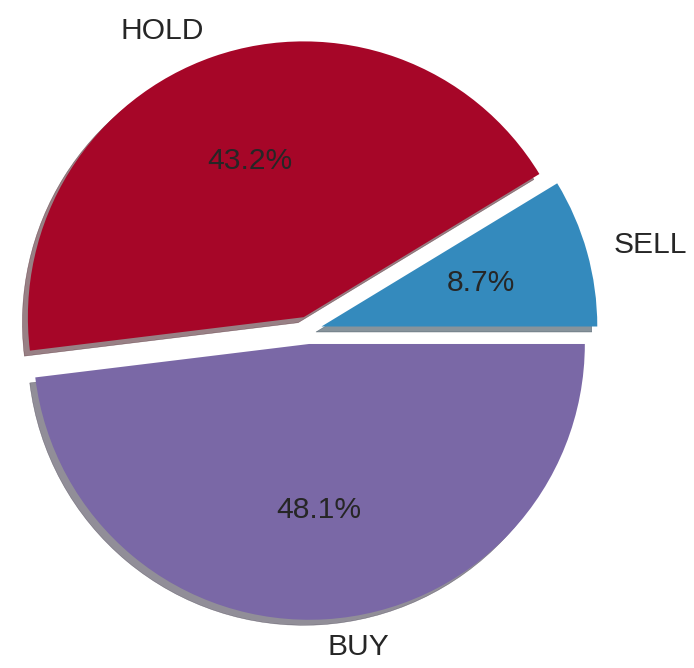

In [41]:
pie_stock(xgboost.predict_proba(one_report))